In [ ]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy

In [203]:
##FCC Data from June 2019 (Most current)
fcc_bbnd_june19 = pd.read_csv('../data/FCC_Broadband/TN-Fixed-Jun2019-v1.csv')

##For details on original columns: https://www.fcc.gov/general/explanation-broadband-deployment-data
# Code	Technology of Transmission
# 10	Asymmetric xDSL
# 11	ADSL2, ADSL2+
# 12	VDSL
# 20	Symmetric xDSL*
# 30	Other Copper Wireline (all copper-wire based technologies other than xDSL; Ethernet over copper and T-1 are examples)
# 40	Cable Modem other than DOCSIS 1, 1.1, 2.0, 3.0, or 3.1
# 41	Cable Modem – DOCSIS 1, 1.1 or 2.0
# 42	Cable Modem – DOCSIS 3.0
# 43	Cable Modem – DOCSIS 3.1
# 50	Optical Carrier / Fiber to the end user (Fiber to the home or business end user, does not include “fiber to the curb”)
# 60	Satellite
# 70	Terrestrial Fixed Wireless
# 90	Electric Power Line
# 0	All Other

## Urban Area definitions from 2018 Census Geographies 
## 'R' = Rural 'C' = Urban Cluster (2,500-50,000) 'U' = Urbanized Area (50,000+) 
urban_area_shape = gpd.read_file('../data/UrbanAreaShape2018/tl_2018_us_uac10.shp')

## Define central point of TN census tracts from 2010 Census Geographies
centroid_df = pd.read_csv('../data/CenPop2010_Mean_TR47.txt', converters={'TRACTCE': lambda x: str(x), 'COUNTYFP': lambda y: str(y)})

print(fcc_bbnd_june19.shape)
print(fcc_bbnd_june19.info())

print(urban_area_shape.shape)
print(urban_area_shape.info())

print(centroid_df.shape)
print(centroid_df.info())

(1484085, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484085 entries, 0 to 1484084
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   LogRecNo            1484085 non-null  int64  
 1   Provider_Id         1484085 non-null  int64  
 2   FRN                 1484085 non-null  int64  
 3   ProviderName        1484085 non-null  object 
 4   DBAName             1484085 non-null  object 
 5   HoldingCompanyName  1484085 non-null  object 
 6   HocoNum             1484085 non-null  int64  
 7   HocoFinal           1484085 non-null  object 
 8   StateAbbr           1484085 non-null  object 
 9   BlockCode           1484085 non-null  int64  
 10  TechCode            1484085 non-null  int64  
 11  Consumer            1484085 non-null  int64  
 12  MaxAdDown           1484085 non-null  float64
 13  MaxAdUp             1484085 non-null  float64
 14  Business            1484085 non-null  int64  
 15  M

In [204]:
## TN Tracts shape
tract_shape = gpd.read_file('../data/shapefiles/tl_2018_47_tract.shp')

In [205]:
tract_shape.crs
tract_shape.head()
tract_shape = tract_shape[['GEOID', 'geometry']]

In [206]:
urban_area_shape = urban_area_shape[['GEOID10', 'NAME10', 'UATYP10', 'ALAND10', 'geometry']]

In [207]:
print(fcc_bbnd_june19.groupby('TechCode').size())
print('\n')
print(fcc_bbnd_june19.groupby('Consumer').size())
print('\n')
print(fcc_bbnd_june19.groupby('Business').size())
print('\n')
print(fcc_bbnd_june19.groupby(['Consumer','Business']).size())

TechCode
10     66864
11    112629
12     67315
20       834
30      9860
40       334
41        61
42     15317
43    121866
50     68334
60    944385
70     76286
dtype: int64


Consumer
0     261604
1    1222481
dtype: int64


Business
0     258113
1    1225972
dtype: int64


Consumer  Business
0         1           261604
1         0           258113
          1           964368
dtype: int64


In [208]:
## Add column for census tract
fcc_bbnd_june19['TractCode'] = fcc_bbnd_june19['BlockCode'].apply(lambda x: str(x)[0:11])

In [209]:
## Drop extraneous columns
all_june19 = fcc_bbnd_june19.drop(['FRN', 'DBAName', 'HoldingCompanyName', 'HocoFinal', 'StateAbbr'], axis=1, inplace=False)

In [210]:
## Add frames with only sat and no sat

only_sat_june19 = fcc_bbnd_june19.loc[fcc_bbnd_june19['TechCode'] == 60]
no_sat_june19 = fcc_bbnd_june19.loc[fcc_bbnd_june19['TechCode'] != 60]

print(all_june19.groupby('TractCode').size())
print(only_sat_june19.groupby('TractCode').size())
print(no_sat_june19.groupby('TractCode').size())
print('\n')
print(all_june19.groupby('BlockCode').size())
print(only_sat_june19.groupby('BlockCode').size())
print(no_sat_june19.groupby('BlockCode').size())
print('\n')
print(all_june19.shape)
print(only_sat_june19.shape)
print(no_sat_june19.shape)

TractCode
47001020100     762
47001020201     509
47001020202     998
47001020300     397
47001020400     765
               ... 
47189030800    2146
47189030901     936
47189030903    1467
47189030904    1659
47189031000    2456
Length: 1497, dtype: int64
TractCode
47001020100     480
47001020201     309
47001020202     614
47001020300     200
47001020400     440
               ... 
47189030800    1512
47189030901     633
47189030903    1076
47189030904    1173
47189031000    1648
Length: 1497, dtype: int64
TractCode
47001020100    282
47001020201    200
47001020202    384
47001020300    197
47001020400    325
              ... 
47189030800    634
47189030901    303
47189030903    391
47189030904    486
47189031000    808
Length: 1497, dtype: int64


BlockCode
470010201001000    5
470010201001001    4
470010201001002    7
470010201001003    6
470010201001004    7
                  ..
471890310004062    8
471890310004063    5
471890310004064    5
471890310004065    7
471890310004066   

In [211]:
## Find how many census blocks are in each tract
count_blocks = no_sat_june19.groupby('TractCode')['BlockCode'].nunique().reset_index()
count_blocks.rename(columns={'BlockCode': 'CountBlocks'}, inplace=True)
count_blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TractCode    1497 non-null   object
 1   CountBlocks  1497 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.5+ KB


In [212]:
## Merge block count into fcc df
no_sat_june19_countd = no_sat_june19.merge(count_blocks, how='inner', on='TractCode')

In [213]:
## Make dfs which are subsetted for Consumer and Business service, as well as both
consumer_june19 =  no_sat_june19_countd[no_sat_june19_countd['Consumer'] == 1]
business_june19 =  no_sat_june19_countd[no_sat_june19_countd['Business'] == 1]
both_cnsm_biz_june19 = consumer_june19[consumer_june19['Business'] == 1]

consumer_june19_3mbps = consumer_june19[consumer_june19['MaxAdDown'] >= 3.0]
consumer_june19_12mbps = consumer_june19[consumer_june19['MaxAdDown'] >= 12.0]
consumer_june19_25mbps = consumer_june19[consumer_june19['MaxAdDown'] >= 25.0]

business_june19_250mbps = business_june19[business_june19['MaxCIRDown'] >= 250.0]

In [214]:
## Determine how many blocks in a tract have a *choice of services* at levels of any / 3 / 12 / 25 mbps
provider_block_choice = consumer_june19.groupby(['BlockCode', 'TractCode'])['Consumer'].sum().reset_index()
provider_block_choices = provider_block_choice[provider_block_choice['Consumer'] >= 2]

provider_block_choice_3mbps = consumer_june19_3mbps.groupby(['BlockCode', 'TractCode'])['Consumer'].sum().reset_index()
provider_block_choices_3mbps = provider_block_choice_3mbps[provider_block_choice_3mbps['Consumer'] >= 2]

provider_block_choice_12mbps = consumer_june19_12mbps.groupby(['BlockCode', 'TractCode'])['Consumer'].sum().reset_index()
provider_block_choices_12mbps = provider_block_choice_12mbps[provider_block_choice_12mbps['Consumer'] >= 2]

provider_block_choice_25mbps = consumer_june19_25mbps.groupby(['BlockCode', 'TractCode'])['Consumer'].sum().reset_index()
provider_block_choices_25mbps = provider_block_choice_25mbps[provider_block_choice_25mbps['Consumer'] >= 2]

block_choices_counted = provider_block_choices.groupby(['TractCode']).count().reset_index()
block_choices_counted.drop('BlockCode', axis=1, inplace=True)
block_choices_counted.rename(columns={'Consumer': 'Blocks With Choice'}, inplace=True)

block_choices_counted_3mbps = provider_block_choices_3mbps.groupby(['TractCode']).count().reset_index()
block_choices_counted_3mbps.drop('BlockCode', axis=1, inplace=True)
block_choices_counted_3mbps.rename(columns={'Consumer': 'Blocks With Choice 3mbps'}, inplace=True)

block_choices_counted_12mbps = provider_block_choices_12mbps.groupby(['TractCode']).count().reset_index()
block_choices_counted_12mbps.drop('BlockCode', axis=1, inplace=True)
block_choices_counted_12mbps.rename(columns={'Consumer': 'Blocks With Choice 12mbps'}, inplace=True)

block_choices_counted_25mbps = provider_block_choices_25mbps.groupby(['TractCode']).count().reset_index()
block_choices_counted_25mbps.drop('BlockCode', axis=1, inplace=True)
block_choices_counted_25mbps.rename(columns={'Consumer': 'Blocks With Choice 25mbps'}, inplace=True)

consumer_choice_dfs = [block_choices_counted, block_choices_counted_3mbps, block_choices_counted_12mbps, block_choices_counted_25mbps]

In [215]:
## Create dataframe to show proportion of blocks in each tract with a choice
choice_levels_add = count_blocks.copy()
for df in consumer_choice_dfs:    
    choice_levels_add = choice_levels_add.merge(df, how='left', on='TractCode')
    
choice_levels_add['Prop With Choice'] = round((100 * choice_levels_add['Blocks With Choice'] / choice_levels_add['CountBlocks']), 2)
choice_levels_add['Prop With Choice 3mbps'] = round((100 * choice_levels_add['Blocks With Choice 3mbps'] / choice_levels_add['CountBlocks']), 2)
choice_levels_add['Prop With Choice 12mbps'] = round((100 * choice_levels_add['Blocks With Choice 12mbps'] / choice_levels_add['CountBlocks']), 2)
choice_levels_add['Prop With Choice 25mbps'] = round((100 * choice_levels_add['Blocks With Choice 25mbps'] / choice_levels_add['CountBlocks']), 2)

In [216]:
choice_levels_add = choice_levels_add.fillna(0)
choice_levels_add.to_csv('../out/choice_levels.csv')

In [217]:
## Determine how many blocks in a tract are served *by a given provider*.
provider_block_served_consumer = consumer_june19.groupby(['ProviderName', 'BlockCode', 'TractCode'])['Consumer'].max().reset_index()
provider_block_served_business = business_june19.groupby(['ProviderName', 'BlockCode', 'TractCode'])['Business'].max().reset_index()

sum_blocks_by_tract_consumer = provider_block_served_consumer.groupby(['ProviderName','TractCode'])['Consumer'].sum().reset_index()
sum_blocks_by_tract_business = provider_block_served_business.groupby(['ProviderName','TractCode'])['Business'].sum().reset_index()

sum_blocks_by_tract_consumer.rename(columns={'Consumer': 'Consumer Blocks Served'}, inplace=True)
sum_blocks_by_tract_business.rename(columns={'Business': 'Business Blocks Served'}, inplace=True)

In [218]:
## Determine how many provider blocks in a tract are served at levels of 3 / 12 / 25 mbps as per this: https://www.fcc.gov/consumers/guides/household-broadband-guide
provider_block_served_consumer_3mbps = consumer_june19_3mbps.groupby(['ProviderName', 'BlockCode', 'TractCode'])['Consumer'].max().reset_index()
provider_block_served_consumer_12mbps = consumer_june19_12mbps.groupby(['ProviderName', 'BlockCode', 'TractCode'])['Consumer'].max().reset_index()
provider_block_served_consumer_25mbps = consumer_june19_25mbps.groupby(['ProviderName', 'BlockCode', 'TractCode'])['Consumer'].max().reset_index()

provider_block_served_business_250mbps = business_june19_250mbps.groupby(['ProviderName', 'BlockCode', 'TractCode'])['Business'].max().reset_index()

sum_blocks_by_tract_consumer_3mbps = provider_block_served_consumer_3mbps.groupby(['ProviderName','TractCode'])['Consumer'].sum().reset_index()
sum_blocks_by_tract_consumer_12mbps = provider_block_served_consumer_12mbps.groupby(['ProviderName','TractCode'])['Consumer'].sum().reset_index()
sum_blocks_by_tract_consumer_25mbps = provider_block_served_consumer_25mbps.groupby(['ProviderName','TractCode'])['Consumer'].sum().reset_index()

sum_blocks_by_tract_business_250mbps = provider_block_served_business_250mbps.groupby(['ProviderName','TractCode'])['Business'].sum().reset_index()

sum_blocks_by_tract_consumer_3mbps.rename(columns={'Consumer': 'Consumer Blocks Served 3mbps'}, inplace=True)
sum_blocks_by_tract_consumer_12mbps.rename(columns={'Consumer': 'Consumer Blocks Served 12mbps'}, inplace=True)
sum_blocks_by_tract_consumer_25mbps.rename(columns={'Consumer': 'Consumer Blocks Served 25mbps'}, inplace=True)

sum_blocks_by_tract_business_250mbps.rename(columns={'Business': 'Business Blocks Served 250mbps'}, inplace=True)

In [219]:
## Determine how many blocks in a tract are served *by anyone*.
block_served_consumer = consumer_june19.groupby(['BlockCode', 'TractCode'])['Consumer'].max().reset_index()
block_served_business = business_june19.groupby(['BlockCode', 'TractCode'])['Business'].max().reset_index()

blocks_served_any_pro_consumer = block_served_consumer.groupby(['TractCode'])['Consumer'].sum().reset_index()
blocks_served_any_pro_business = block_served_business.groupby(['TractCode'])['Business'].sum().reset_index()

blocks_served_any_pro_consumer.rename(columns={'Consumer': 'Consumer Blocks Served Any Pro'}, inplace=True)
blocks_served_any_pro_business.rename(columns={'Business': 'Business Blocks Served Any Pro'}, inplace=True)

In [220]:
## Determine how many blocks in a tract are served at levels of 3 / 12 / 25 mbps by any provider as per this: https://www.fcc.gov/consumers/guides/household-broadband-guide
block_served_consumer_3mbps = consumer_june19_3mbps.groupby(['BlockCode', 'TractCode'])['Consumer'].max().reset_index()
block_served_consumer_12mbps = consumer_june19_12mbps.groupby(['BlockCode', 'TractCode'])['Consumer'].max().reset_index()
block_served_consumer_25mbps = consumer_june19_25mbps.groupby(['BlockCode', 'TractCode'])['Consumer'].max().reset_index()

block_served_business_250mbps = business_june19_250mbps.groupby(['BlockCode', 'TractCode'])['Business'].max().reset_index()

blocks_served_any_pro_consumer_3mbps = block_served_consumer_3mbps.groupby(['TractCode'])['Consumer'].sum().reset_index()
blocks_served_any_pro_consumer_12mbps = block_served_consumer_12mbps.groupby(['TractCode'])['Consumer'].sum().reset_index()
blocks_served_any_pro_consumer_25mbps = block_served_consumer_25mbps.groupby(['TractCode'])['Consumer'].sum().reset_index()

blocks_served_any_pro_business_250mbps = block_served_business_250mbps.groupby(['TractCode'])['Business'].sum().reset_index()

blocks_served_any_pro_consumer_3mbps.rename(columns={'Consumer': 'Consumer Blocks Served Any Pro 3mbps'}, inplace=True)
blocks_served_any_pro_consumer_12mbps.rename(columns={'Consumer': 'Consumer Blocks Served Any Pro 12mbps'}, inplace=True)
blocks_served_any_pro_consumer_25mbps.rename(columns={'Consumer': 'Consumer Blocks Served Any Pro 25mbps'}, inplace=True)

blocks_served_any_pro_business_250mbps.rename(columns={'Business': 'Business Blocks Served Any Pro 250mbps'}, inplace=True)


In [221]:
consumer_count_any_pro = count_blocks.copy()
consumer_any_pro_dfs = [blocks_served_any_pro_consumer, blocks_served_any_pro_consumer_3mbps, blocks_served_any_pro_consumer_12mbps, blocks_served_any_pro_consumer_25mbps]
for df in consumer_any_pro_dfs:    
    consumer_count_any_pro = consumer_count_any_pro.merge(df, how='left', on='TractCode')

consumer_count_any_pro['Prop Served By Any'] = round((100 * consumer_count_any_pro['Consumer Blocks Served Any Pro'] / consumer_count_any_pro['CountBlocks']), 2)
consumer_count_any_pro['Prop Served By Any 3mbps'] = round((100 * consumer_count_any_pro['Consumer Blocks Served Any Pro 3mbps'] / consumer_count_any_pro['CountBlocks']), 2)
consumer_count_any_pro['Prop Served By Any 12mbps'] = round((100 * consumer_count_any_pro['Consumer Blocks Served Any Pro 12mbps'] / consumer_count_any_pro['CountBlocks']), 2)
consumer_count_any_pro['Prop Served By Any 25mbps'] = round((100 * consumer_count_any_pro['Consumer Blocks Served Any Pro 25mbps'] / consumer_count_any_pro['CountBlocks']), 2)

In [222]:
consumer_count_any_pro = consumer_count_any_pro.fillna(0)
consumer_count_any_pro.to_csv('../out/consumers_any_provider.csv')

In [223]:
short_consumer_june19 = consumer_june19[['ProviderName', 'TechCode', 'TractCode', 'CountBlocks']]

short_consumer_combo = short_consumer_june19.merge(sum_blocks_by_tract_consumer, how='left', on=['ProviderName', 'TractCode'])
short_consumer_combo = short_consumer_combo.merge(sum_blocks_by_tract_consumer_3mbps, how='left', on=['ProviderName', 'TractCode'])
short_consumer_combo = short_consumer_combo.merge(sum_blocks_by_tract_consumer_12mbps, how='left', on=['ProviderName', 'TractCode'])
short_consumer_combo = short_consumer_combo.merge(sum_blocks_by_tract_consumer_25mbps, how='left', on=['ProviderName', 'TractCode'])

short_consumer_combo.drop_duplicates(inplace=True)
short_consumer_combo = short_consumer_combo.fillna(0)
short_consumer_combo = short_consumer_combo.astype({'Consumer Blocks Served 3mbps': 'int64', 
                                                    'Consumer Blocks Served 12mbps': 'int64',
                                                    'Consumer Blocks Served 25mbps': 'int64'}, copy=False)
short_consumer_combo.info()
##short_consumer_combo.to_csv('../out/consumer_reduced.csv')
##def combine_frame_on_tract

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9436 entries, 0 to 512740
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ProviderName                   9436 non-null   object
 1   TechCode                       9436 non-null   int64 
 2   TractCode                      9436 non-null   object
 3   CountBlocks                    9436 non-null   int64 
 4   Consumer Blocks Served         9436 non-null   int64 
 5   Consumer Blocks Served 3mbps   9436 non-null   int64 
 6   Consumer Blocks Served 12mbps  9436 non-null   int64 
 7   Consumer Blocks Served 25mbps  9436 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 663.5+ KB


In [224]:
## In each tract that is served by a provider, how many blocks do they serve?
## Consumer:

##block_sum_consumers = consumer_june19.groupby(['TractCode', 'ProviderName', 'CountBlocks', 'TechCode'])['Consumer'].sum().reset_index()
## Business
##block_sum_businesses = business_june19.groupby(['TractCode', 'ProviderName', 'CountBlocks', 'TechCode'])['Business'].sum().reset_index()

short_consumer_combo['Proportion Served'] = round((100 * short_consumer_combo['Consumer Blocks Served'] / short_consumer_combo['CountBlocks']), 2)
short_consumer_combo['Proportion Served 3mbps'] = round((100 * short_consumer_combo['Consumer Blocks Served 3mbps'] / short_consumer_combo['CountBlocks']), 2)
short_consumer_combo['Proportion Served 12mbps'] = round((100 * short_consumer_combo['Consumer Blocks Served 12mbps'] / short_consumer_combo['CountBlocks']), 2)
short_consumer_combo['Proportion Served 25mbps'] = round((100 * short_consumer_combo['Consumer Blocks Served 25mbps'] / short_consumer_combo['CountBlocks']), 2)

short_consumer_combo['Substantially Served'] = short_consumer_combo['Proportion Served'] >= 30.0
short_consumer_combo['Substantially Served 3mbps'] = short_consumer_combo['Proportion Served 3mbps'] >= 30.0
short_consumer_combo['Substantially Served 12mbps'] = short_consumer_combo['Proportion Served 12mbps'] >= 30.0
short_consumer_combo['Substantially Served 25mbps'] = short_consumer_combo['Proportion Served 25mbps'] >= 30.0

In [225]:
short_consumer_for_set = short_consumer_combo.copy()

In [226]:
consumer_combo_no_code = short_consumer_combo.drop('TechCode', axis=1, inplace=False)
consumer_combo_no_code.drop_duplicates(inplace=True)
set_codes = short_consumer_for_set.groupby(['ProviderName', 'TractCode'])['TechCode'].agg(lambda x : set(x)).reset_index()
consumer_set_codes = consumer_combo_no_code.merge(set_codes, how='left', on=['ProviderName', 'TractCode'])

In [227]:
consumer_set_codes['Minimally Residential'] = consumer_set_codes['TractCode'].map(lambda x: x[5:7] == '98')
consumer_set_codes['Water Area'] = consumer_set_codes['TractCode'].map(lambda x: x[5:7] == '99')
consumer_set_codes['Consumer Service N/A'] = consumer_set_codes['Water Area'] ^ consumer_set_codes['Minimally Residential']

In [228]:
## TODO: Expand the set to a column for each
consumer_set_codes.rename({'TechCode': 'TechCodes Set'}, axis=1, inplace=True)
consumer_set_codes.to_csv('../out/consumers_served.csv')

In [229]:
providers_serving_tract = consumer_set_codes.groupby('TractCode')[['Substantially Served', 'Substantially Served 3mbps', 'Substantially Served 12mbps', 'Substantially Served 25mbps']].sum().reset_index()
providers_serving_tract.to_csv('../out/providers_serving_tract.csv')

In [230]:
# census_url = 'https://api.census.gov/data'
# year = '2018'
# dataset = 'acs/acs5'
# base_url = '/'.join([census_url, year, dataset])
# get_tract_vars = ['B01003_001E']
# get_tract_vars = ["NAME"] + get_tract_vars
# predicates = {}
# predicates['get'] = ','.join(get_tract_vars)
# predicates['for'] = 'tract:*'
# predicates['in'] = 'state:47'
# request = requests.get(base_url, params=predicates)
# col_names = ['NAME', 'Population', 'state', 'county', 'tract']
# census_tract_df = pd.DataFrame(data=request.json()[0:], columns=col_names)

In [231]:
# census_tract_df['TractCode'] = census_tract_df['state'] + census_tract_df['county'] + census_tract_df['tract']
# census_tract_two_col = census_tract_df[['Population', 'TractCode']]

In [240]:
# mappable_consumers = tract_shape.merge(consumer_set_codes, how='left', left_on='GEOID', right_on='TractCode')
# mappable_provider_tract = tract_shape.merge(providers_serving_tract, how='left', left_on='GEOID', right_on='TractCode')
# mappable_consumers.to_csv('../out/mappable_consumer_with_providers.csv')
# mappable_provider_tract.to_csv('../out/mappable_providers_serving_tract.csv')

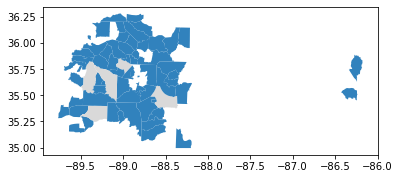

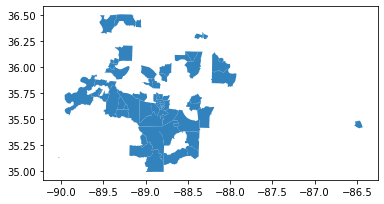

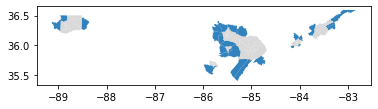

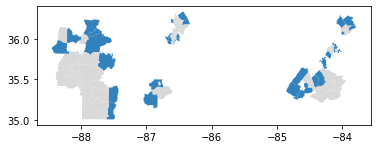

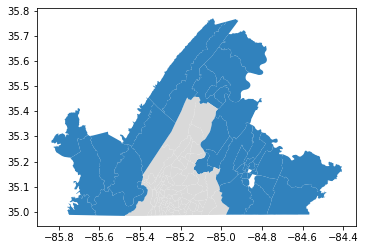

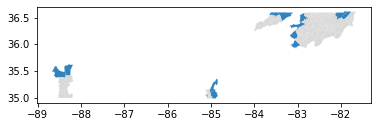

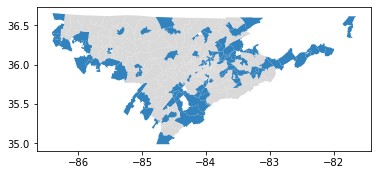

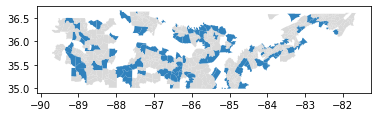

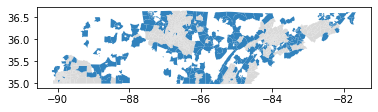

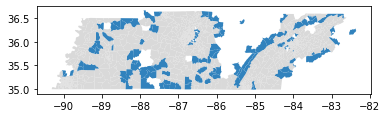

In [241]:
map_top_providers_dfs = []
top_n_providers = list(consumer_set_codes.groupby('ProviderName').size().sort_values().tail(10).index)
rp = copy.copy(cm.get_cmap('tab20c'))
for x in top_n_providers:
    provider_sub = consumer_set_codes[consumer_set_codes['ProviderName'] == x]
    mappable = tract_shape.merge(provider_sub, how='left', left_on='GEOID', right_on='TractCode')
    map_top_providers_dfs.append(mappable)
for provider_map in map_top_providers_dfs:
    provider_map.plot(column='Substantially Served', cmap=rp)

In [243]:
charter_sub = consumer_set_codes[consumer_set_codes['ProviderName'] == 'Charter Communications, Inc.']

In [244]:
charter_geo = tract_shape.merge(charter_sub, how='outer', left_on='GEOID', right_on='TractCode')

In [245]:
charter_geo_filled = charter_geo.fillna(0.0001)

<AxesSubplot:>

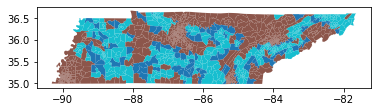

In [246]:
charter_geo_filled.plot(column='Substantially Served')

In [247]:
sub_tract = no_sat_june19[no_sat_june19['TractCode'] == '47189031000']
sub_tract.head(20)
sub_tract.groupby(['BlockCode']).size()

BlockCode
471890310001002    4
471890310001006    2
471890310001007    2
471890310001008    2
471890310001009    2
                  ..
471890310004062    4
471890310004063    1
471890310004064    1
471890310004065    3
471890310004066    4
Length: 365, dtype: int64

In [248]:
centroid_df.drop('POPULATION', axis=1, inplace=True)

In [249]:
centroid_df = centroid_df.astype({'STATEFP': 'str'}, copy=False)

In [250]:
centroid_df['TractCode'] = centroid_df['STATEFP'] + centroid_df['COUNTYFP'] + centroid_df['TRACTCE']

In [252]:
##Compare centroid tracts to fcc data tracts - to show there are no tracts without data in the fcc no satellite group
no_sat_tract = no_sat_june19['TractCode'].unique()
centroid_tract = centroid_df['TractCode']

In [253]:
centroid_df['geometry'] = centroid_df.apply(lambda x: Point((float(x['LONGITUDE']), float(x['LATITUDE']))), axis=1)

In [254]:
centroid_geo = gpd.GeoDataFrame(centroid_df, crs = urban_area_shape.crs, geometry = centroid_df['geometry'])
centroid_geo = centroid_geo[['LATITUDE', 'LONGITUDE', 'TractCode', 'geometry']]

In [255]:
centroid_geo.shape

(1497, 4)

In [256]:
ua_of_census_tracts = gpd.sjoin(centroid_geo, urban_area_shape, op = 'within')
ua_of_census_tracts.head()

,LATITUDE,LONGITUDE,TractCode,geometry,index_right,GEOID10,NAME10,UATYP10,ALAND10
0,36.001828,-84.268796,47001020100,POINT (-84.26880 36.00183),865,45640,"Knoxville, TN",U,1134806494
1,36.017235,-84.213287,47001020201,POINT (-84.21329 36.01723),865,45640,"Knoxville, TN",U,1134806494
2,36.022426,-84.228827,47001020202,POINT (-84.22883 36.02243),865,45640,"Knoxville, TN",U,1134806494
3,36.041852,-84.226627,47001020300,POINT (-84.22663 36.04185),865,45640,"Knoxville, TN",U,1134806494
4,36.026023,-84.255785,47001020400,POINT (-84.25579 36.02602),865,45640,"Knoxville, TN",U,1134806494


In [257]:
ua_of_census_tracts.drop('index_right', axis=1, inplace=True)

In [258]:
##Find any rows where Tract is not in the spatially merged df
centroid_geo_rural = centroid_geo[centroid_geo['TractCode'].isin(ua_of_census_tracts['TractCode'].tolist()) == False]
centroid_geo_rural.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 606 entries, 7 to 1496
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LATITUDE   606 non-null    float64 
 1   LONGITUDE  606 non-null    float64 
 2   TractCode  606 non-null    object  
 3   geometry   606 non-null    geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 23.7+ KB


In [259]:
centroid_rural_match_cols = pd.concat([centroid_geo_rural, pd.DataFrame(columns=['GEOID10', 'NAME10', 'UATYP10', 'ALAND10'])])
centroid_rural_match_cols['UATYP10'] = 'R'
centroid_rural_match_cols['ALAND10'] = centroid_rural_match_cols['ALAND10'].fillna(np.nan)

In [260]:
centroid_rural_match_cols.head()

,LATITUDE,LONGITUDE,TractCode,geometry,GEOID10,NAME10,UATYP10,ALAND10
7,36.187349,-84.212278,47001020700,POINT (-84.21228 36.18735),NaN,NaN,R,NaN
8,36.209390,-84.141887,47001020800,POINT (-84.14189 36.20939),NaN,NaN,R,NaN
9,36.202792,-84.030302,47001020901,POINT (-84.03030 36.20279),NaN,NaN,R,NaN
11,36.052115,-84.293492,47001021000,POINT (-84.29349 36.05212),NaN,NaN,R,NaN
12,36.076311,-84.182827,47001021100,POINT (-84.18283 36.07631),NaN,NaN,R,NaN


In [261]:
tract_by_ua_w_rural = pd.concat([centroid_rural_match_cols, ua_of_census_tracts], axis=0)

In [262]:
print(tract_by_ua_w_rural.shape)
print(tract_by_ua_w_rural.info())
tract_by_ua_w_rural.head(50)
tract_by_ua_w_rural['UATYP10'].unique()

(1497, 8)
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1497 entries, 7 to 1491
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LATITUDE   1497 non-null   float64 
 1   LONGITUDE  1497 non-null   float64 
 2   TractCode  1497 non-null   object  
 3   geometry   1497 non-null   geometry
 4   GEOID10    891 non-null    object  
 5   NAME10     891 non-null    object  
 6   UATYP10    1497 non-null   object  
 7   ALAND10    891 non-null    float64 
dtypes: float64(3), geometry(1), object(4)
memory usage: 105.3+ KB
None


array(['R', 'U', 'C'], dtype=object)

In [263]:
census_url = 'https://api.census.gov/data'
year = '2010'
dataset = 'dec/sf1'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['P001001']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'urban area:*'  ## zctas
##predicates['in'] = 'state:47'
request = requests.get(base_url, params=predicates)
##col_names = ['NAME', 'Population', 'zip']
census_df = pd.DataFrame(data=request.json()[1:])

##https://api.census.gov/data/2010/dec/sf1?get=P001001,NAME&for=urban%20rural:*&in=state:01%20county:087%20county%20subdivision:93230%20place/remainder%20(or%20part):77304%20tract%20(or%20part):231900

In [264]:
census_url = 'https://api.census.gov/data'
year = '2018'
dataset = 'acs/acs5'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['B01003_001E']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'urban area:*'  ## zctas
##predicates['in'] = 'urban area:*'

request = requests.get(base_url, params=predicates)
##col_names = ['NAME', 'Population', 'zip']
census_df = pd.DataFrame(data=request.json()[1:])